In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # якщо зображення раптом RGB
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_data = datasets.ImageFolder("./train", transform=transform)
test_data  = datasets.ImageFolder("./test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

num_classes = len(train_data.classes)
print("Класи:", train_data.classes)

Класи: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 48→24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 24→12
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

model = CNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_epoch(loader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(loader, leave=False)  # прогрес-бар для батчів
    for X, y in loop:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

        # оновлення прогрес-бару
        loop.set_description(f"Train")
        loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    return total_loss / len(loader), correct / total


def test_epoch(loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(loader, leave=False)
    with torch.no_grad():
        for X, y in loop:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

            loop.set_description("Test")
            loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    return total_loss / len(loader), correct / total

In [7]:
epochs = 30
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
    test_loss, test_acc = test_epoch(test_loader, model, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
          f"Val loss: {test_loss:.4f} | Val acc: {test_acc:.4f}")



Epoch 1/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 1.6066 | Train acc: 0.3688 | Val loss: 1.4422 | Val acc: 0.4503

Epoch 2/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 1.3833 | Train acc: 0.4648 | Val loss: 1.3266 | Val acc: 0.4901

Epoch 3/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 1.2663 | Train acc: 0.5177 | Val loss: 1.2658 | Val acc: 0.5131

Epoch 4/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 1.1697 | Train acc: 0.5559 | Val loss: 1.2378 | Val acc: 0.5298

Epoch 5/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 1.0685 | Train acc: 0.5966 | Val loss: 1.2171 | Val acc: 0.5354

Epoch 6/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.9659 | Train acc: 0.6404 | Val loss: 1.2304 | Val acc: 0.5429

Epoch 7/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.8672 | Train acc: 0.6740 | Val loss: 1.2645 | Val acc: 0.5449

Epoch 8/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.7687 | Train acc: 0.7121 | Val loss: 1.3296 | Val acc: 0.5511

Epoch 9/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.6615 | Train acc: 0.7553 | Val loss: 1.4025 | Val acc: 0.5478

Epoch 10/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.5875 | Train acc: 0.7822 | Val loss: 1.4692 | Val acc: 0.5472

Epoch 11/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.5127 | Train acc: 0.8091 | Val loss: 1.5322 | Val acc: 0.5503

Epoch 12/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.4494 | Train acc: 0.8330 | Val loss: 1.6327 | Val acc: 0.5545

Epoch 13/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.3974 | Train acc: 0.8519 | Val loss: 1.7720 | Val acc: 0.5511

Epoch 14/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.3587 | Train acc: 0.8660 | Val loss: 1.8258 | Val acc: 0.5507

Epoch 15/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.3277 | Train acc: 0.8789 | Val loss: 2.0291 | Val acc: 0.5485

Epoch 16/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2957 | Train acc: 0.8919 | Val loss: 2.0652 | Val acc: 0.5460

Epoch 17/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2714 | Train acc: 0.9019 | Val loss: 2.2081 | Val acc: 0.5486

Epoch 18/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2570 | Train acc: 0.9043 | Val loss: 2.2038 | Val acc: 0.5534

Epoch 19/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2338 | Train acc: 0.9138 | Val loss: 2.3840 | Val acc: 0.5506

Epoch 20/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2256 | Train acc: 0.9182 | Val loss: 2.5368 | Val acc: 0.5520

Epoch 21/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2142 | Train acc: 0.9215 | Val loss: 2.5585 | Val acc: 0.5376

Epoch 22/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.2084 | Train acc: 0.9244 | Val loss: 2.5344 | Val acc: 0.5486

Epoch 23/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1932 | Train acc: 0.9291 | Val loss: 2.4779 | Val acc: 0.5425

Epoch 24/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1909 | Train acc: 0.9299 | Val loss: 2.7394 | Val acc: 0.5450

Epoch 25/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1845 | Train acc: 0.9325 | Val loss: 2.7932 | Val acc: 0.5527

Epoch 26/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1701 | Train acc: 0.9370 | Val loss: 2.9556 | Val acc: 0.5475

Epoch 27/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1737 | Train acc: 0.9366 | Val loss: 2.8310 | Val acc: 0.5412

Epoch 28/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1647 | Train acc: 0.9406 | Val loss: 2.9462 | Val acc: 0.5467

Epoch 29/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1624 | Train acc: 0.9427 | Val loss: 2.9479 | Val acc: 0.5486

Epoch 30/30


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Train loss: 0.1537 | Train acc: 0.9448 | Val loss: 3.0452 | Val acc: 0.5497


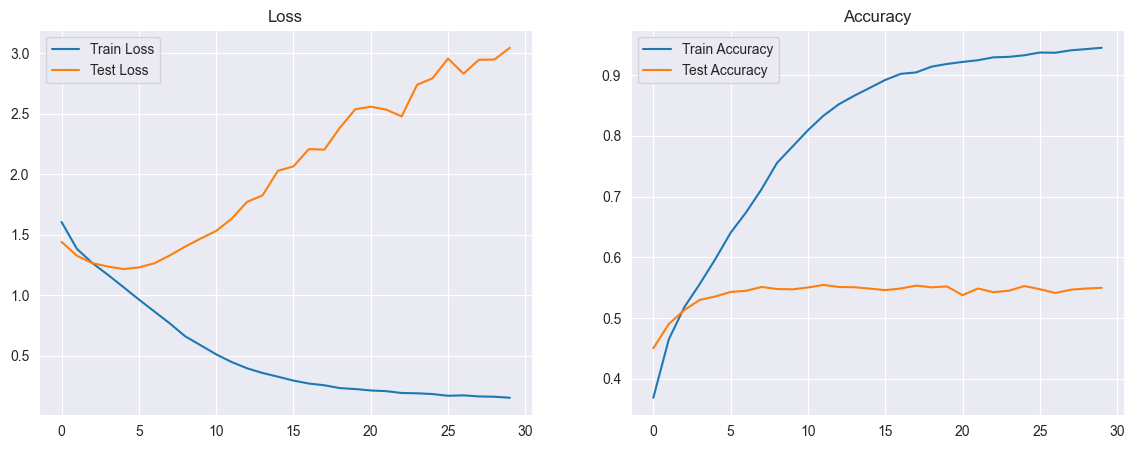

In [8]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()
